## QUESTION 5: DATA MINING OPS

- In this notebook, we shall be looking at some data minig operations to answer some business qustions that will be formulated prior to the operations themselves.
- As usual, the first step is to prepare the data for mining.

### 1. DATA LOADING & CLEANING

In [1]:
import pandas as pd
from mlxtend.frequent_patterns import fpgrowth, association_rules, apriori
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose # For potential time series exploration
import numpy as np

In [2]:
# Load the dataset
df = pd.read_csv(r'C:\Users\user\Desktop\online_retail_II.csv')
print(df.head())
print(df.info())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice 

- Here we'll go through some data cleaning steps to prepare the dataset for the mining operations

In [3]:
# Create a cleaned copy of the dataframe
df_cleaned = df.copy()

# Remove rows where 'Description' is missing
df_cleaned.dropna(subset=['Description'], inplace=True)
# Verify the number of missing values in 'Description' after removal
print(f"Number of missing values in Description after removal: {df_cleaned['Description'].isnull().sum()}")

Number of missing values in Description after removal: 0


In [4]:
# Filter out rows where 'Quantity' is less than or equal to 0
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]

# Verify the minimum value of 'Quantity' after filtering
print(f"Minimum value of Quantity after filtering: {df_cleaned['Quantity'].min()}")

Minimum value of Quantity after filtering: 1


In [5]:
# List of string columns to strip whitespace from
string_cols = ['Description', 'StockCode', 'Country']

# Apply the strip function to each of the string columns
for col in string_cols:
    df_cleaned[col] = df_cleaned[col].str.strip()

# You can optionally check a few values to see if whitespace has been removed
print(df_cleaned['Description'].head())
print(df_cleaned['StockCode'].head())
print(df_cleaned['Country'].head())

0    15CM CHRISTMAS GLASS BALL 20 LIGHTS
1                     PINK CHERRY LIGHTS
2                    WHITE CHERRY LIGHTS
3            RECORD FRAME 7" SINGLE SIZE
4         STRAWBERRY CERAMIC TRINKET BOX
Name: Description, dtype: object
0     85048
1    79323P
2    79323W
3     22041
4     21232
Name: StockCode, dtype: object
0    United Kingdom
1    United Kingdom
2    United Kingdom
3    United Kingdom
4    United Kingdom
Name: Country, dtype: object


In [6]:
# Count the number of missing values in 'Customer ID'
missing_customer_id = df_cleaned['Customer ID'].isnull().sum()
print(f"Number of missing values in Customer ID in the cleaned data: {missing_customer_id}")

Number of missing values in Customer ID in the cleaned data: 237108


- Here, we'll create some new features that could be beneficial in our analytics

In [7]:
# Convert 'InvoiceDate' to datetime objects if it's not already
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

# Create a new column for just the date
df_cleaned['Date'] = df_cleaned['InvoiceDate'].dt.date

# Create a new column for just the time
df_cleaned['Time'] = df_cleaned['InvoiceDate'].dt.time

# Display the first few rows with the new columns
print(df_cleaned[['InvoiceDate', 'Date', 'Time']].head())

          InvoiceDate        Date      Time
0 2009-12-01 07:45:00  2009-12-01  07:45:00
1 2009-12-01 07:45:00  2009-12-01  07:45:00
2 2009-12-01 07:45:00  2009-12-01  07:45:00
3 2009-12-01 07:45:00  2009-12-01  07:45:00
4 2009-12-01 07:45:00  2009-12-01  07:45:00


In [8]:
# Create the 'Sales' column by multiplying 'Quantity' and 'Price'
df_cleaned['Sales'] = df_cleaned['Quantity'] * df_cleaned['Price']

# Round the 'Sales' column to two decimal places
df_cleaned['Sales'] = df_cleaned['Sales'].round(1)

# Display the first few rows with the new 'Sales' column
print(df_cleaned[['Quantity', 'Price', 'Sales']].head())

# Check the data type of the 'Sales' column
print(df_cleaned['Sales'].dtype)

# Get some descriptive statistics for the 'Sales' column
print(df_cleaned['Sales'].describe())

   Quantity  Price  Sales
0        12   6.95   83.4
1        12   6.75   81.0
2        12   6.75   81.0
3        48   2.10  100.8
4        24   1.25   30.0
float64
count    1.042728e+06
mean     1.996249e+01
std      2.179975e+02
min     -5.359440e+04
25%      3.900000e+00
50%      1.000000e+01
75%      1.770000e+01
max      1.684696e+05
Name: Sales, dtype: float64


In [9]:
# Round the 'Price' column to two decimal places
df_cleaned['Price'] = df_cleaned['Price'].round(1)

# Display the first few rows of 'UnitPrice' and 'Sales' after rounding
print(df_cleaned[['Price', 'Sales']].head())

# Verify the data types (should remain float)
print(df_cleaned[['Price', 'Sales']].dtypes)

   Price  Sales
0    7.0   83.4
1    6.8   81.0
2    6.8   81.0
3    2.1  100.8
4    1.2   30.0
Price    float64
Sales    float64
dtype: object


In [10]:
# Fill NaN values in 'Customer ID' with a placeholder (safer way)
df_cleaned = df_cleaned.fillna({'Customer ID': -1})

# Convert 'Customer ID' to integer type
df_cleaned['Customer ID'] = df_cleaned['Customer ID'].astype(int)

# Display the first few values of 'Customer ID'
print(df_cleaned['Customer ID'].head())

# Verify the data type (should be int)
print(df_cleaned['Customer ID'].dtype)

# Count the number of placeholder values (-1)
print(f"Number of placeholder values (-1) in Customer ID: {df_cleaned[df_cleaned['Customer ID'] == -1]['Customer ID'].count()}")

0    13085
1    13085
2    13085
3    13085
4    13085
Name: Customer ID, dtype: int64
int64
Number of placeholder values (-1) in Customer ID: 237108


In [11]:
# Check for duplicate rows based on all columns
duplicate_rows = df_cleaned.duplicated()

# Print the number of duplicate rows
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

# Remove duplicate rows, keeping the first occurrence
df_cleaned = df_cleaned.drop_duplicates()

# Verify the number of rows after removing duplicates
print(f"Number of rows after removing duplicates: {len(df_cleaned)}")

Number of duplicate rows: 33831
Number of rows after removing duplicates: 1008897


In [12]:
# Count the occurrences of descriptions containing "?"
question_mark_descriptions = df_cleaned[df_cleaned['Description'] == '?']
print(f"Number of transactions with '?' in description: {len(question_mark_descriptions)}")
print(question_mark_descriptions['Description'].unique()[:10])

# Count the occurrences of "Manual" in description
manual_descriptions = df_cleaned[df_cleaned['Description'] == 'Manual']
print(f"\nNumber of transactions with 'Manual' description: {len(manual_descriptions)}")
print("\nUnique StockCodes for 'Manual' items:")
print(manual_descriptions['StockCode'].unique())

Number of transactions with '?' in description: 9
['?']

Number of transactions with 'Manual' description: 859

Unique StockCodes for 'Manual' items:
['M' 'm']


In [13]:
# Remove rows where 'Description' contains '?' (after stripping whitespace)
df_cleaned['Description'] = df_cleaned['Description'].str.strip()
df_cleaned = df_cleaned[~df_cleaned['Description'].str.contains('\?', na=False)]

# Verify the number of transactions with '?' in description after removal
print(f"Number of transactions with '?' in description after removal: {len(df_cleaned[df_cleaned['Description'].str.contains('\?', na=False)])}")

<>:3: SyntaxWarning: invalid escape sequence '\?'
<>:6: SyntaxWarning: invalid escape sequence '\?'
<>:3: SyntaxWarning: invalid escape sequence '\?'
<>:6: SyntaxWarning: invalid escape sequence '\?'
C:\Users\user\AppData\Local\Temp\ipykernel_12240\2161245359.py:3: SyntaxWarning: invalid escape sequence '\?'
  df_cleaned = df_cleaned[~df_cleaned['Description'].str.contains('\?', na=False)]
C:\Users\user\AppData\Local\Temp\ipykernel_12240\2161245359.py:6: SyntaxWarning: invalid escape sequence '\?'
  print(f"Number of transactions with '?' in description after removal: {len(df_cleaned[df_cleaned['Description'].str.contains('\?', na=False)])}")


Number of transactions with '?' in description after removal: 0


In [14]:
# Drop the original 'InvoiceDate' column
df_cleaned = df_cleaned.drop('InvoiceDate', axis=1)

# Display the first few rows to confirm the column has been dropped
print(df_cleaned.head())

# Check the columns in the DataFrame
print(df_cleaned.columns)

  Invoice StockCode                          Description  Quantity  Price  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12    7.0   
1  489434    79323P                   PINK CHERRY LIGHTS        12    6.8   
2  489434    79323W                  WHITE CHERRY LIGHTS        12    6.8   
3  489434     22041          RECORD FRAME 7" SINGLE SIZE        48    2.1   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24    1.2   

   Customer ID         Country        Date      Time  Sales  
0        13085  United Kingdom  2009-12-01  07:45:00   83.4  
1        13085  United Kingdom  2009-12-01  07:45:00   81.0  
2        13085  United Kingdom  2009-12-01  07:45:00   81.0  
3        13085  United Kingdom  2009-12-01  07:45:00  100.8  
4        13085  United Kingdom  2009-12-01  07:45:00   30.0  
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'Price',
       'Customer ID', 'Country', 'Date', 'Time', 'Sales'],
      dtype='object')


In [15]:
# Get descriptive statistics for 'Price'
print(df_cleaned['Price'].describe())

# Find the number of unique values in 'Price'
print(f"\nNumber of unique values in Price: {df_cleaned['Price'].nunique()}")

# Look at the value counts of 'Price', especially the lower end
print("\nValue counts for lower Price values:")
print(df_cleaned['Price'].value_counts().sort_index().head(20))

# Look at the value counts of 'Price', especially the higher end
print("\nValue counts for higher Price values:")
print(df_cleaned['Price'].value_counts().sort_index(ascending=False).head(20))

# Check for negative values in 'Price'
negative_prices = df_cleaned[df_cleaned['Price'] < 0]
print(f"\nNumber of transactions with negative Price: {len(negative_prices)}")
print("\nExamples of transactions with negative Price:")
print(negative_prices.head())

# Check for zero values in 'Price'
zero_prices = df_cleaned[df_cleaned['Price'] == 0]
print(f"\nNumber of transactions with zero Price: {len(zero_prices)}")
print("\nExamples of transactions with zero Price:")
print(zero_prices.head())

count    1.008886e+06
mean     3.913853e+00
std      9.516062e+01
min     -5.359440e+04
25%      1.200000e+00
50%      2.100000e+00
75%      4.100000e+00
max      2.511110e+04
Name: Price, dtype: float64

Number of unique values in Price: 1550

Value counts for lower Price values:
Price
-53594.4        1
-44031.8        1
-38925.9        1
-11062.1        2
 0.0         1057
 0.1         1408
 0.2         6032
 0.3         7617
 0.4        56075
 0.5          255
 0.6        33320
 0.7         2253
 0.8        88835
 0.9          428
 1.0         3836
 1.1         3441
 1.2        99485
 1.3         3343
 1.4        23101
 1.5         2326
Name: count, dtype: int64

Value counts for higher Price values:
Price
25111.1    1
13541.3    1
11062.1    1
10953.5    2
10468.8    3
8985.6     1
8142.8     1
7044.8     1
6958.2     2
6706.7     1
5876.3     1
5843.7     1
5795.9     1
5117.0     1
4620.9     1
4505.2     1
4287.6     1
4217.6     1
4161.1     2
3949.3     1
Name: count, dtype: i

In [16]:
# Examine transactions with negative Price
print(negative_prices[['Invoice', 'StockCode', 'Description', 'Quantity', 'Price', 'Customer ID']].head(10))

        Invoice StockCode      Description  Quantity    Price  Customer ID
179403  A506401         B  Adjust bad debt         1 -53594.4           -1
276274  A516228         B  Adjust bad debt         1 -44031.8           -1
403472  A528059         B  Adjust bad debt         1 -38925.9           -1
825444  A563186         B  Adjust bad debt         1 -11062.1           -1
825445  A563187         B  Adjust bad debt         1 -11062.1           -1


In [17]:
# Remove these rows from the DataFrame
df_cleaned = df_cleaned[~((df_cleaned['Price'] < 0) & (df_cleaned['Description'] == 'Adjust bad debt'))]

### 2. EXPLORATIONS & VISUALIZATIONS
- We can look at some vizualizations to better understand the dataset before we go into mining

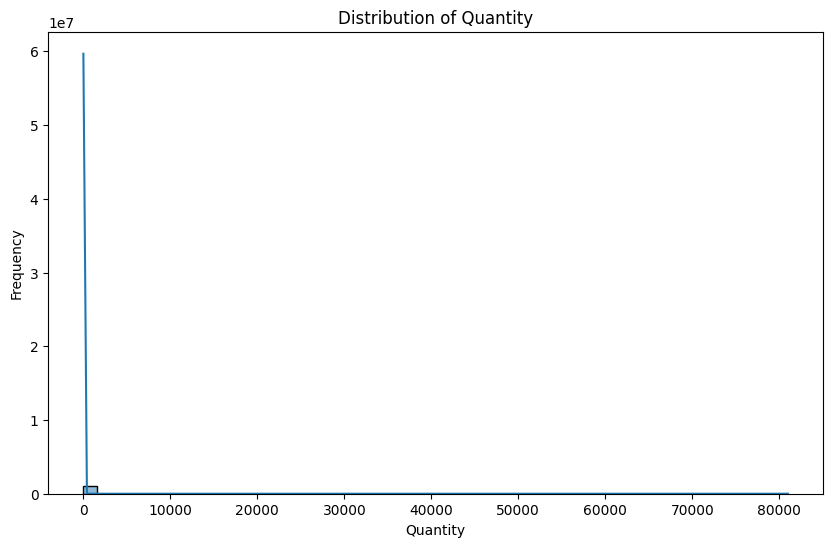

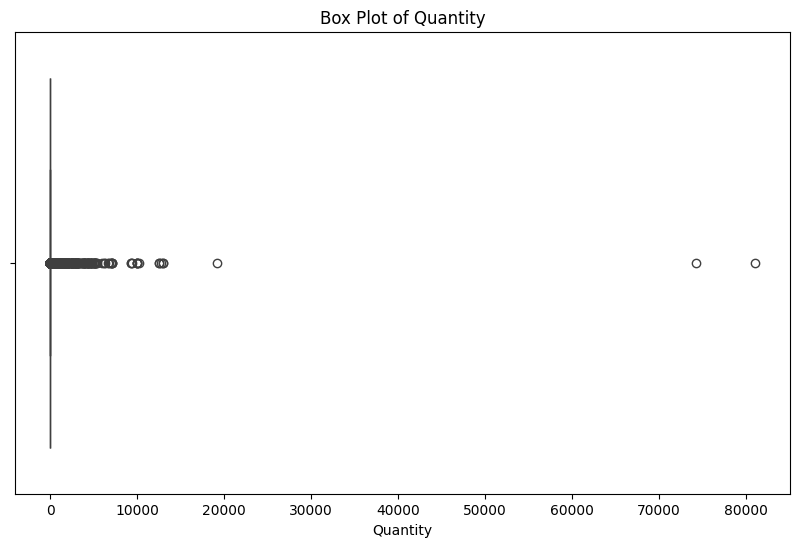

In [18]:
# Distribution of Quantity
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Quantity'], bins=50, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['Quantity'])
plt.title('Box Plot of Quantity')
plt.xlabel('Quantity')
plt.show()

- The majority of transactions involve relatively small quantities (between 1 and 12).
- There is a significant number of transactions with much larger quantities, indicating bulk purchases or potentially some data entry anomalies. These outliers could influence analyses that are sensitive to extreme values (like calculating averages).
- The distribution is likely right-skewed, meaning the tail extends more towards higher quantities (as suggested by the median being lower than the upper quartile and the presence of many high outliers).

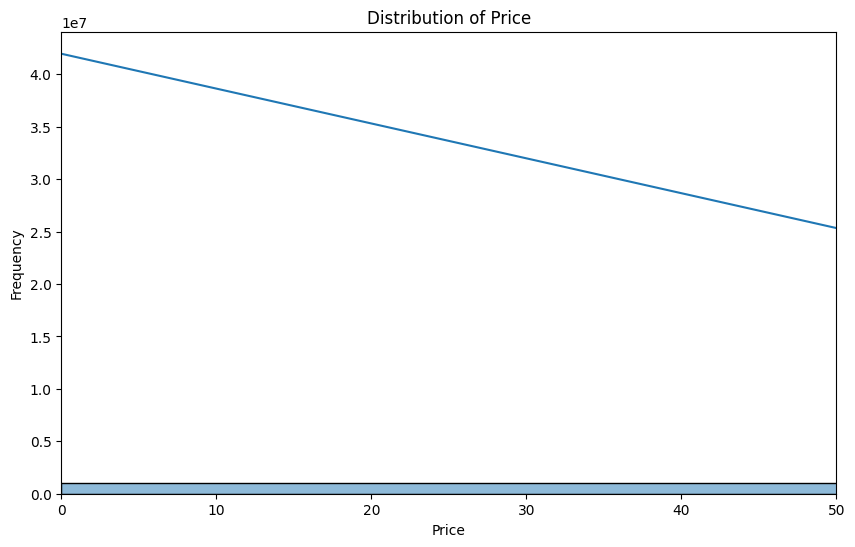

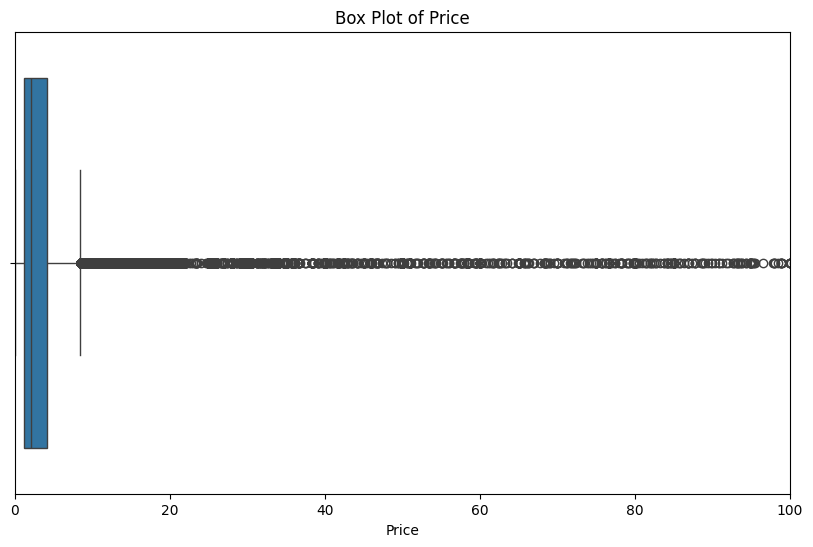

count    1.008881e+06
mean     4.071152e+00
std      5.040879e+01
min      0.000000e+00
25%      1.200000e+00
50%      2.100000e+00
75%      4.100000e+00
max      2.511110e+04
Name: Price, dtype: float64


In [19]:
#Distribution of Price

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Price'], bins=50, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 50)  # Limit x-axis for better visibility of the main distribution
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['Price'])
plt.title('Box Plot of Price')
plt.xlabel('Price')
plt.xlim(0, 100) # Limit x-axis for better visibility
plt.show()

print(df_cleaned['Price'].describe())

- The left edge of the box is very close to 0, indicating the 25th percentile (Q1). This means that 25% of the items have a unit price close to zero.
- The right edge of the box is around 4, representing the 75th percentile (Q3). So, 75% of the items have a unit price of approximately 4 or less.
- The line inside the box is around 2, which is the median (Q2). Half of the items have a unit price of 2 or less, and half have a unit price of 2 or more.
- There's a very large number of circles extending far beyond the right whisker. These represent outliers with significantly higher unit prices. Some of these outliers go well beyond the x-axis limit of 100, indicating that there are items with very high unit prices in the dataset.

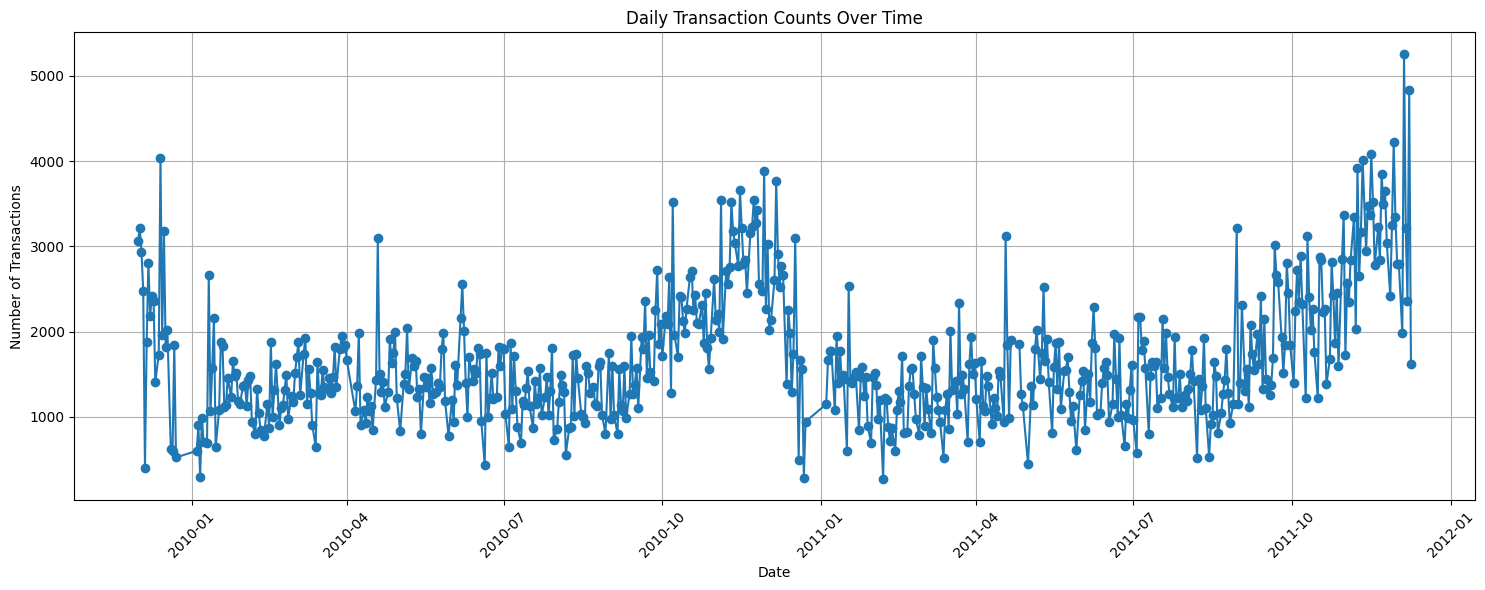

In [20]:
# Extract just the date part from the 'Date' column
daily_transactions = df_cleaned['Date'].value_counts().sort_index()

# Create a line plot of daily transaction counts
plt.figure(figsize=(15, 6))
plt.plot(daily_transactions.index, daily_transactions.values, marker='o', linestyle='-')
plt.title('Daily Transaction Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_12240\953290005.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Frequency', data=top_plot_df, palette='magma')


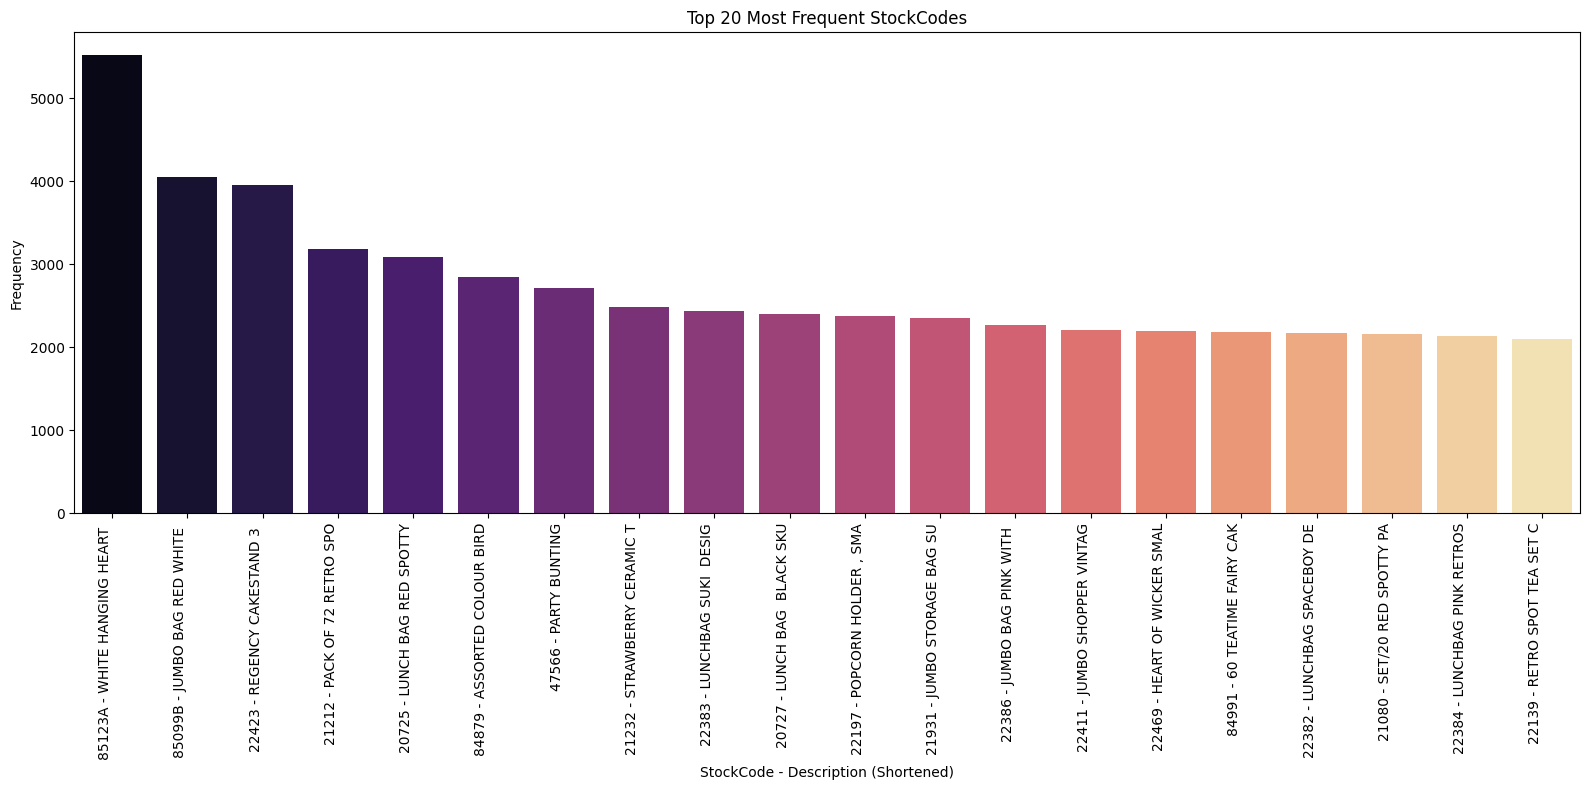

In [21]:
# Get the top 20 most frequent StockCodes
top_n = 20
top_stockcodes = df_cleaned['StockCode'].value_counts().nlargest(top_n).index.tolist()

# Filter the DataFrame to include only rows with the top StockCodes
top_products_df = df_cleaned[df_cleaned['StockCode'].isin(top_stockcodes)]

# Get the description for each of the top StockCodes (taking the first one encountered)
top_descriptions = top_products_df.groupby('StockCode')['Description'].first()

# Create a DataFrame for plotting
top_plot_df = pd.DataFrame({
    'StockCode': top_stockcodes,
    'Frequency': df_cleaned['StockCode'].value_counts().nlargest(top_n).values
})

# Merge with descriptions
top_plot_df = top_plot_df.merge(top_descriptions, on='StockCode', how='left')

# Create combined labels for the x-axis
top_plot_df['Label'] = top_plot_df['StockCode'] + ' - ' + top_plot_df['Description'].str[:20] # Shorten description

# Create a bar plot of the top StockCodes with Combined Labels
plt.figure(figsize=(16, 8))
sns.barplot(x='Label', y='Frequency', data=top_plot_df, palette='magma')
plt.title(f'Top {top_n} Most Frequent StockCodes')
plt.xlabel('StockCode - Description (Shortened)')
plt.ylabel('Frequency')
plt.xticks(rotation=90, ha='right') # Rotate and right-align for better readability
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_12240\3345428419.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Customer ID', y='Count', data=top_plot_df, palette='viridis')


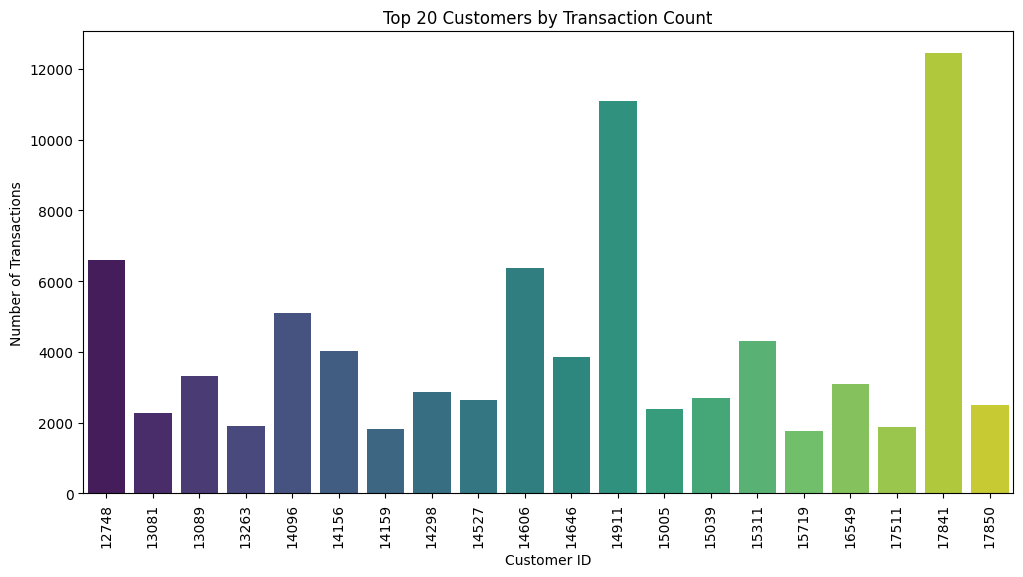

In [22]:
# Filter out rows where CustomerID is -1
valid_customer_df = df_cleaned[df_cleaned['Customer ID'] != -1]

# Count the occurrences of valid CustomerIDs
valid_customer_counts = valid_customer_df['Customer ID'].value_counts()

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Customer ID': valid_customer_counts.index,
    'Count': valid_customer_counts.values
})

# Create the bar graph (for top N customers)
top_n = 20  # You can adjust this number
top_plot_df = plot_df.nlargest(top_n, 'Count')

plt.figure(figsize=(12, 6))
sns.barplot(x='Customer ID', y='Count', data=top_plot_df, palette='viridis')
plt.title(f'Top {top_n} Customers by Transaction Count')
plt.xlabel('Customer ID')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)
plt.show()

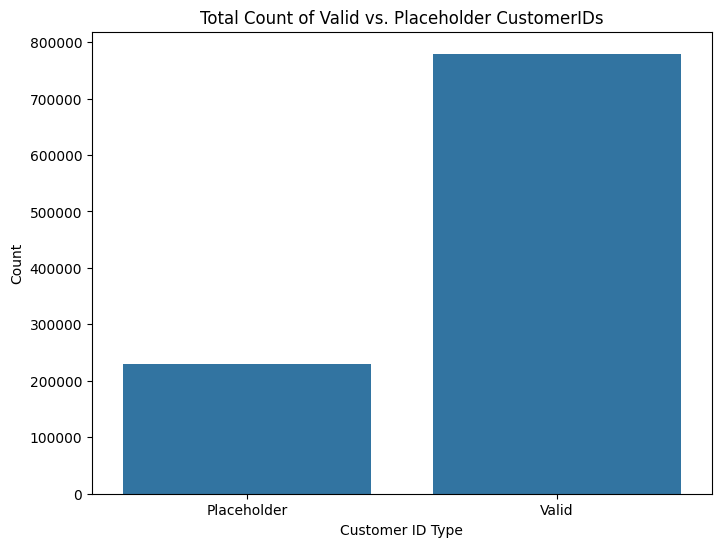

In [23]:
# Count the occurrences of -1 (Placeholder)
placeholder_count = (df_cleaned['Customer ID'] == -1).sum()

# Count the occurrences of valid (non -1) Customer IDs
valid_count = (df_cleaned['Customer ID'] != -1).sum()

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'CustomerID_Type': ['Placeholder', 'Valid'],
    'Count': [placeholder_count, valid_count]
})

# Create the bar graph
plt.figure(figsize=(8, 6))
sns.barplot(x='CustomerID_Type', y='Count', data=plot_df)
plt.title('Total Count of Valid vs. Placeholder CustomerIDs')
plt.xlabel('Customer ID Type')
plt.ylabel('Count')
plt.show()

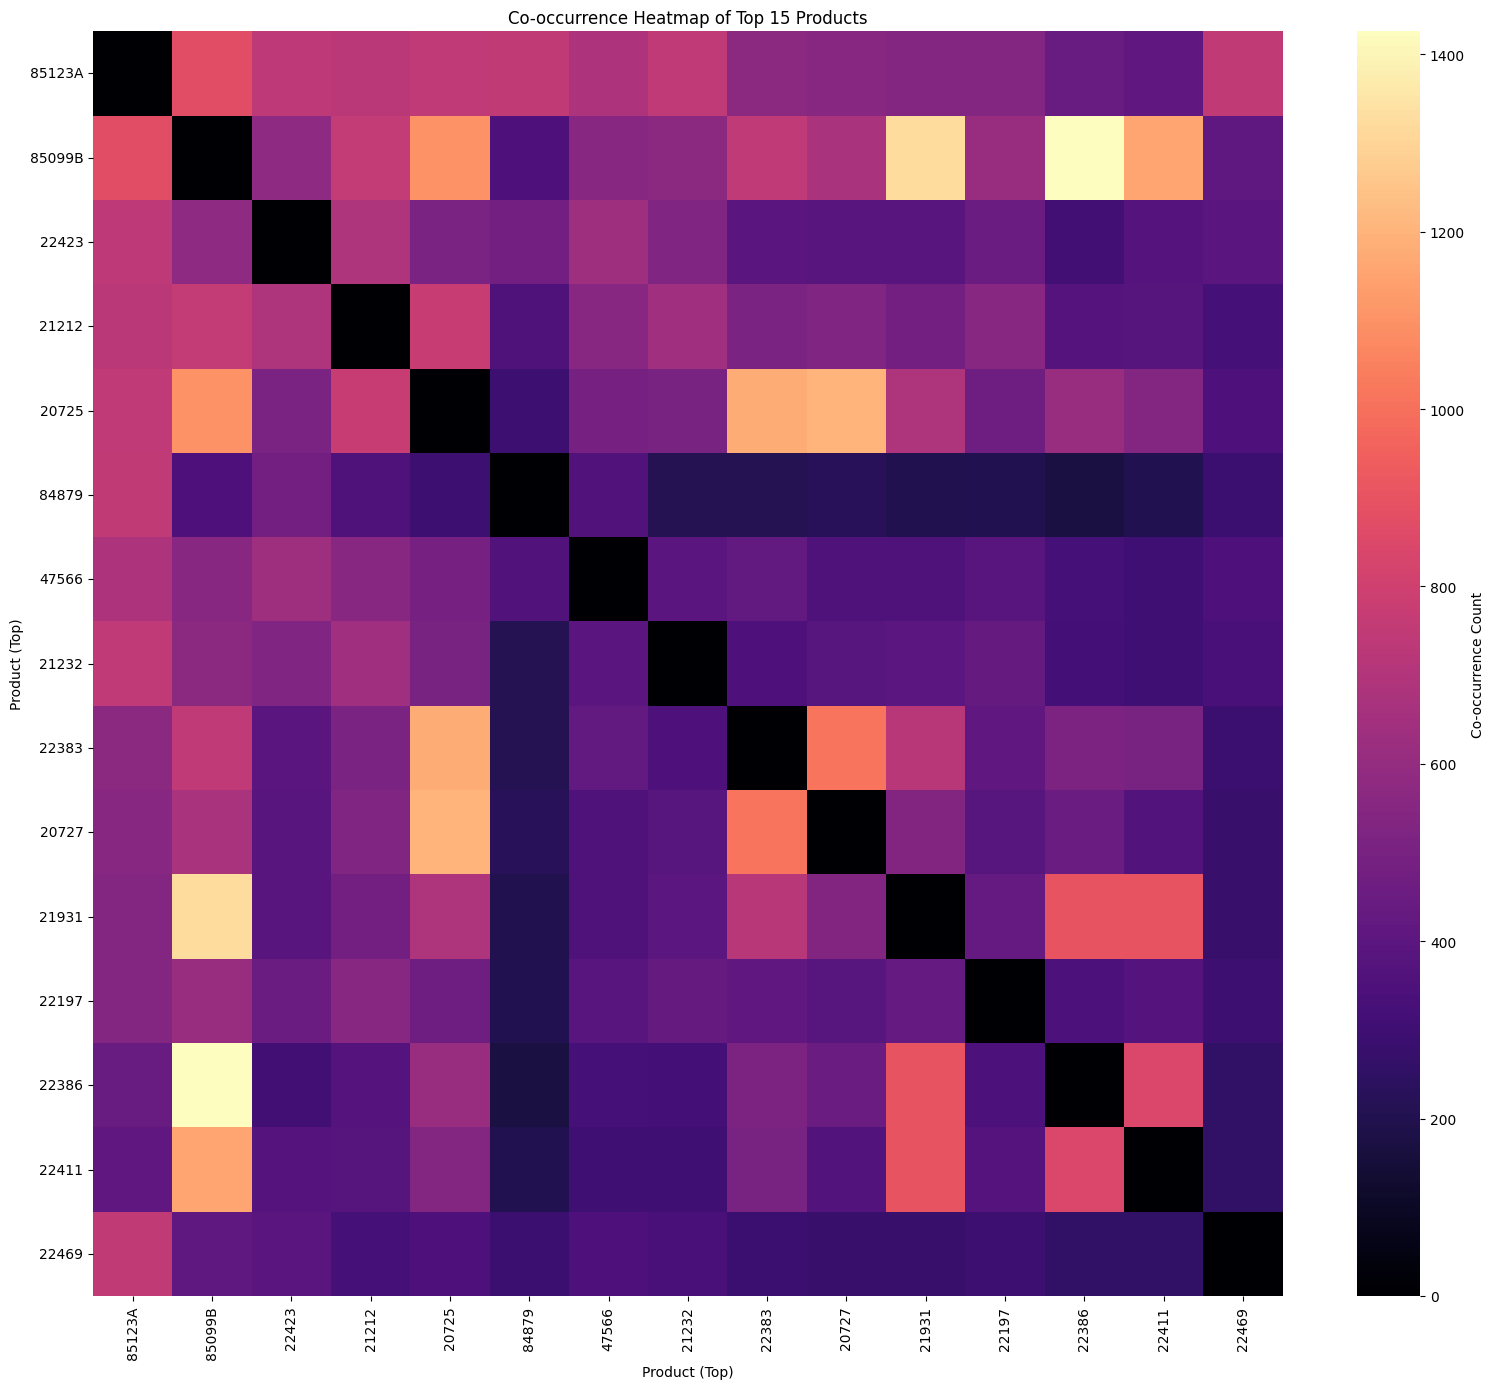

In [24]:
# Group by 'Invoice' and collect 'StockCode'
transactions = df_cleaned.groupby('Invoice')['StockCode'].apply(list).reset_index()

# Use TransactionEncoder
te = TransactionEncoder()
te_array = te.fit(transactions['StockCode']).transform(transactions['StockCode'])
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Identify the top N most frequently purchased products
top_n_products = 15  # Let's focus on the top 15 for better visualization
frequent_items = df_encoded.sum().nlargest(top_n_products).index
df_top_encoded = df_encoded[frequent_items].astype(int) # Cast to integer

# Calculate the co-occurrence matrix
cooccurrence_matrix = df_top_encoded.T.dot(df_top_encoded)

# Set the diagonal to 0
for i in range(cooccurrence_matrix.shape[0]):
    cooccurrence_matrix.iloc[i, i] = 0

# Create a heatmap of the co-occurrence matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cooccurrence_matrix, cmap='magma', annot=False, cbar_kws={'label': 'Co-occurrence Count'})
plt.title(f'Co-occurrence Heatmap of Top {top_n_products} Products')
plt.xlabel('Product (Top)')
plt.ylabel('Product (Top)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 3. MINING AND EVALUATION

##### I. ASSOCIATION RULE MINING 
method- Frequent Itemset Mining using the FP-Growth algorithm.

The goal here is to discover which sets of items (products, in our case) appear frequently together in the same transactions. This is a crucial first step towards generating association rules.

In [25]:

# Define the minimum support threshold (as a fraction of transactions)
min_support = 0.01  # Adjust this value as needed

# Run the FP-Growth algorithm
frequent_itemsets = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)

# Print the frequent itemsets
print(f"Number of frequent itemsets found: {len(frequent_itemsets)}")
print("\nFrequent Itemsets:")
print(frequent_itemsets.head())

# Get some statistics on the frequent itemsets
print(f"\nDescriptive statistics of frequent itemset support:")
print(frequent_itemsets['support'].describe())

Number of frequent itemsets found: 1322

Frequent Itemsets:
    support itemsets
0  0.060443  (21232)
1  0.028000  (21523)
2  0.019337  (21871)
3  0.017227  (22064)
4  0.013776  (22041)

Descriptive statistics of frequent itemset support:
count    1322.000000
mean        0.017402
std         0.010097
min         0.010003
25%         0.011468
50%         0.013801
75%         0.019455
max         0.133297
Name: support, dtype: float64


This tells us that the FP-Growth algorithm, with the minimum support threshold you set (0.01, or 1% of transactions), has identified a total of 1322 unique combinations of items (itemsets) that appear in at least 1% of all the transactions in your dataset.

- support: This column indicates the fraction of total transactions in which the itemset appears.
    - For example:0.060443 for (21232) means that the item with StockCode '21232' was present in approximately 6.04% of all transactions, o.028000 for 21523, and so on.
- itemsets: This column shows the frequent itemset itself. In the first few rows, you see itemsets containing only a single item (e.g., (21232)).
    - As the algorithm finds combinations of items that meet the support threshold, you will also see itemsets with two or more StockCodes (e.g., (21232, 21523) if they frequently occur together).


- count: 1322.000000: Confirms the total number of frequent itemsets.
- mean: 0.017402: The average support of all frequent itemsets is about 1.74%.
- max: 0.133297: The most frequent itemset (which might be a single very popular item or a combination) appears in about 13.33% of all transactions.

In [26]:
# Define the minimum confidence threshold
min_confidence = 0.3
# Adjust this value as needed

# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

# Print the generated rules
print(f"Number of association rules generated: {len(rules)}")
print("\nAssociation Rules:")
print(rules.head())

# Get some descriptive statistics on the rules' metrics
print("\nDescriptive statistics of rule confidence:")
print(rules['confidence'].describe())

print("\nDescriptive statistics of rule lift:")
print(rules['lift'].describe())

Number of association rules generated: 957

Association Rules:
  antecedents consequents  antecedent support  consequent support   support  \
0     (21232)    (85123A)            0.060443            0.133297  0.018493   
1     (22064)     (21232)            0.017227            0.060443  0.010872   
2     (22195)     (22196)            0.020131            0.024351  0.011220   
3     (22196)     (22195)            0.024351            0.020131  0.011220   
4     (21754)    (85123A)            0.051283            0.133297  0.018393   

   confidence       lift  representativity  leverage  conviction  \
0    0.305955   2.295288               1.0  0.010436    1.248770   
1    0.631124  10.441667               1.0  0.009831    2.547081   
2    0.557337  22.887730               1.0  0.010730    2.204043   
3    0.460754  22.887730               1.0  0.010730    1.817110   
4    0.358664   2.690715               1.0  0.011558    1.351403   

   zhangs_metric   jaccard  certainty  kulczynski  
0

- What do these reults say?
    * For starters, we will not consider the rules from representativity to Kulczynski's measure. They are not of much importance. So we'll major on the first 7 rules: antecedents, consequents, antecedent support, consequent support, support, confidence and lift.
    - **Number of rules are 957**
    - What do these terms/measures signify:
        - *antecedents*: The item(s) on the left-hand side of the rule (the "IF" part). For example, (21232) means "IF item with StockCode 21232 is bought...".
        - *consequents*: The item(s) on the right-hand side of the rule (the "THEN" part). For example, (85123A) means "...THEN item with StockCode 22383 is likely to be bought".
        - *antecedent support*: The proportion of transactions that contain the antecedent itemset. For rule 0, item '21232' appears in about 6.04% of transactions.
        - *consequent support*: The proportion of transactions that contain the consequent itemset. For rule 0, item '85123A' appears in about 13.33% of transactions.
        - *support*: The proportion of transactions that contain both the antecedent and the consequent itemsets. For rule 0, '21232' and '85123A' appear together in about 1.85% of transactions.
        - *confidence*: The probability of the consequent being bought given that the antecedent was bought. For rule 0, if '21232' is bought, there is a 30.59% chance that '85123A' is also bought.
        - *lift*: A measure of how much more likely the consequent is bought when the antecedent is bought, compared to their independent probabilities. A lift greater than 1 suggests a positive association. For rule 0, a lift of 2.295 indicates that '85123A' is about 2.295 times more likely to be bought if '21232' is also bought, compared to the likelihood of buying '85123A' on its own.

- In the descriptive statistics:
    - a. For confidence: 
        - *mean*: 0.497273: The average confidence across all 957 rules is approximately 49.7%. This means that, on average, if the antecedent item(s) are bought, the consequent item(s) are bought about 49.7% of the time within those transactions.
        - *max*: 0.918977: The highest confidence among the generated rules is about 91.9%. This suggests that for some rules, the consequent is very likely to be bought if the antecedent is bought.

    - b. For lift:
        - *mean*: 13.245418: The average lift across all rules is approximately 13.2. A lift greater than 1 indicates a positive association between the antecedent and the consequent. An average lift of 10.3 suggests a generally strong positive association in our ruleset.
        - *max*: 52.449718: The highest lift among the rules is remarkably high, at about 52.45. This suggests a very strong positive dependence between the antecedent and consequent in those specific rules. The consequent is about 52.45 times more likely to be purchased when the antecedent is purchased compared to the independent probability of the consequent being purchased.


- We shall now look at filtering these rules to help us identify the most reliable and actionable associations.
- We shall try to see rules with a confidence of at least 0.5 (50%).

In [27]:
# Define the minimum confidence threshold for filtering
min_confidence_threshold = 0.5

# Filter the rules DataFrame
high_confidence_rules = rules[rules['confidence'] >= min_confidence_threshold]

# Print the number of high-confidence rules
print(f"Number of rules with confidence >= {min_confidence_threshold}: {len(high_confidence_rules)}")

# Display the top 10 rules by confidence
print("\nTop 10 Rules by Confidence:")
print(high_confidence_rules.sort_values(by='confidence', ascending=False).head(10))

Number of rules with confidence >= 0.5: 438

Top 10 Rules by Confidence:
               antecedents consequents  antecedent support  \
874  (22698, 22699, 22423)     (22697)            0.011642   
858         (22698, 22699)     (22697)            0.020181   
624  (22356, 20723, 20719)     (20724)            0.011617   
864         (22698, 22423)     (22697)            0.013752   
651  (20723, 22356, 22355)     (20724)            0.012436   
926         (22745, 22746)     (22748)            0.011443   
372         (21080, 21086)     (21094)            0.013826   
875  (22698, 22697, 22423)     (22699)            0.012287   
927         (22748, 22746)     (22745)            0.011766   
857         (22698, 22697)     (22699)            0.021471   

     consequent support   support  confidence       lift  representativity  \
874            0.033659  0.010699    0.918977  27.302278               1.0   
858            0.033659  0.018269    0.905289  26.895630               1.0   
624       

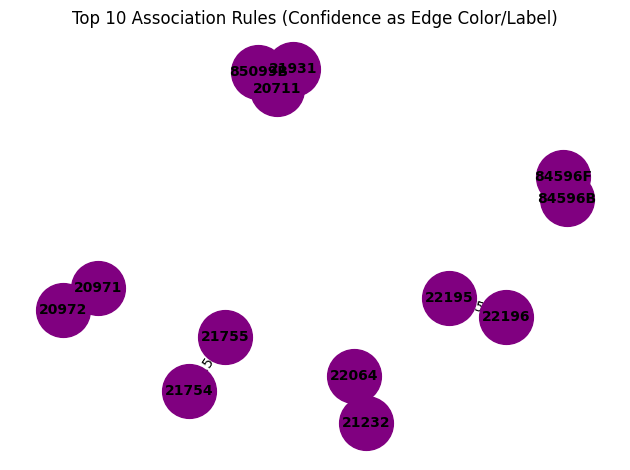

In [31]:
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges and weights (confidence) to the graph from the top rules
for index, row in high_confidence_rules.head(10).iterrows():
    antecedents = tuple(row['antecedents'])
    consequents = tuple(row['consequents'])
    confidence = row['confidence']

    # For simplicity, let's add edges from each antecedent item to each consequent item
    for antecedent in antecedents:
        for consequent in consequents:
            G.add_edge(antecedent, consequent, weight=confidence)

# Define layout for the graph
pos = nx.spring_layout(G)

# Get edge weights for visualization
edge_weights = nx.get_edge_attributes(G, 'weight')

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='purple')

# Draw the edges with weights as labels
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=6, alpha=0.5, edge_color=[edge_weights[e] for e in G.edges()], edge_cmap=plt.cm.viridis)
nx.draw_networkx_edge_labels(G, pos, edge_labels={e: f"{edge_weights[e]:.2f}" for e in G.edges()})

# Draw the node labels (StockCodes)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Top 10 Association Rules (Confidence as Edge Color/Label)")
plt.axis("off")
plt.tight_layout()
plt.show()

#### a. **BUSINESS QUESTION FOR RULE 1: What products are frequently bought together by our customers, and what are the strongest associations between them in terms of purchase likelihood?**

- Data Mining Operation Performed: Association Rule Mining using the FP-Growth algorithm to find frequent itemsets, followed by the generation of association rules, and then filtering these rules based on a minimum confidence threshold of 0.5.

- Results:
    - According to our top 5 association rules:
        rules							Antecedents																							Consequents

        - 874		(22699- ROSES REGENCY TEACUP AND SAUCER, 22423- REGENCY CAKESTAND 3 TIER, 22698- PINK REGENCY TEACUP AND SAUCER) 	(22697- GREEN REGENCY TEACUP AND SAUCER)
        - 858  	(22699- ROSES REGENCY TEACUP AND SAUCER, 22698- PINK REGENCY TEACUP AND SAUCER)     								(22697- GREEN REGENCY TEACUP AND SAUCER) 
        - 624 	(22356- CHARLOTTE BAG,PINK/WHITE SPOTS, 20719- WOODLAND CHARLOTTE BAG, 20723-STRAWBERRY CHARLOTTE BAG)				(20724- RED SPOTTY CHARLOTTE BAG)
        - 864  	(22423- REGENCY CAKESTAND 3 TIER, 22698- PINK REGENCY TEACUP AND SAUCER)     										(22697- GREEN REGENCY TEACUP AND SAUCER)
        - 651  	(22355- CHARLOTTE BAG , SUKI DESIGN, 22356- CHARLOTTE BAG,PINK/WHITE SPOTS, 20723- STRAWBERRY CHARLOTTE BAG)     	(20724- RED SPOTTY CHARLOTTE BAG)

Key Takeaways:
- These top rules show very strong and reliable associations between specific sets of items.
- The high lift values indicate that these are not just due to the popularity of the individual items but represent genuine co-purchasing patterns.
- The antecedents often involve multiple items, suggesting that these items might be part of a set or are used together.

- What are some action points that rrelate to this business question:
    - 1. **Product Recommendations**: If it's an online business, we could suggest the consequent items to customers who have added the antecedent items to their cart.
    - 2. **Product Placement**: In physical stores, placing these associated items near each other.
    - 3. **Product Bundling**: Creating product bundles or hampers that include these frequently co-purchased items.
    - 4. **Marketing Campaigns**: Targeting customers who have bought the antecedents with promotions for the consequents.

#### II. PREDICTIVE ANALYSIS

##### **Business Question: Can we predict which customers are likely to churn (i.e., stop making purchases) in the future based on their past transaction behavior?**

- Data Mining Operation: To address this, we can frame this as a **classification problem**. We'll need to:
- 1. Define "Churn": We need a clear definition of what constitutes a churned customer based on their transaction history. This might involve a period of inactivity.
- 2. Feature Engineering: Create relevant features from the transaction data that might predict churn. These could include recency of last purchase, frequency of purchases, monetary value of purchases, etc.
-  3. Data Preparation: Prepare the data for a classification model, including handling missing values, encoding categorical features (if any are relevant after our initial cleaning), and splitting the data into training and testing sets.
- 4. Model Selection: Choose a suitable classification algorithm (e.g., Logistic Regression, Random Forest, Gradient Boosting).
- 5. Model Training: Train the chosen model on the training data using the engineered features and the churn labels.
- 6. Model Evaluation: Evaluate the model's performance on the testing data using appropriate metrics (e.g., accuracy, precision, recall, F1-score, AUC).

Definition of "Churn": The last transaction date in our dataset will serve as the reference point for defining churn.

In [32]:
# Convert 'Date' to datetime objects if it's not already
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Find the last transaction date in the entire dataset
last_date = df_cleaned['Date'].max()

# Calculate the last purchase date for each customer
last_purchase_dates = df_cleaned.groupby('Customer ID')['Date'].max()
print("Last Purchase Dates for the first 5 customers:")
print(last_purchase_dates.head())

Last Purchase Dates for the first 5 customers:
Customer ID
-1       2011-12-09
 12346   2011-01-18
 12347   2011-12-07
 12348   2011-09-25
 12349   2011-11-21
Name: Date, dtype: datetime64[ns]


- Now that we have the last purchase date for each customer, we can proceed to define our churn label. Let's choose a period of inactivity to define churn. A common approach in retail is to consider customers who haven't made a purchase in the last 3 to 6 months as churned.

- Given the last transaction date in our dataset (which we have seen in the output of the previous cell), let's pick a churn definition. For example, we can say a customer has churned if their last purchase date was more than 90 days (approximately 3 months) before the last_date in our dataset.

In [33]:
# Assuming 'last_date' from the previous step is available
inactivity_days = 90

# Calculate the date before which a customer is considered churned
churn_threshold_date = last_date - pd.Timedelta(days=inactivity_days)

# Create a 'Churned' column: True if last purchase was before the threshold, False otherwise
churned_customers = (last_purchase_dates <= churn_threshold_date).astype(int)

# Create a DataFrame for our target variable
target_df = pd.DataFrame({'Customer ID': churned_customers.index, 'Churned': churned_customers.values})

print("Churn labels for the first 5 customers:")
print(target_df.head())

print("\nDistribution of Churned vs. Not Churned Customers:")
print(target_df['Churned'].value_counts())

Churn labels for the first 5 customers:
   Customer ID  Churned
0           -1        0
1        12346        1
2        12347        0
3        12348        0
4        12349        0

Distribution of Churned vs. Not Churned Customers:
Churned
1    2991
0    2891
Name: count, dtype: int64


The distribution of the two classes has values that are really close and this is generally good for training a classification model. It means the model will have a decent number of examples for both classes to learn from, and we are less likely to run into issues associated with highly imbalanced datasets (where the model might become biased towards the majority class).